# ANN

Table of Contents
- [1. Preprocessing Data](#1-preprocessing-the-data)
- [2. Model for Calls ONLY](#2-model-for-calls-only)
  - [2.1 Stage 1 Model (Binary Classifier)](#21-stage-1-model-binary-classifier)
  - [2.2 Stage 2 Model (Price Prediction)](#22-stage-2-model-price-prediction)
  - [2.3 Testing model](#23-testing-model)
  - [2.4 Hyper param Tuning](#24-hyperparam-tuning)
    - [2.4.1 Hyperparam Tuning (Binary Classifier)](#241-hyperparam-tuning-binary-classifier)
    - [2.4.2 Hyperparam Tuning (Price Prediction)](#242-hyperparam-tuning-price-prediction)
- [3. Model for Puts ONLY](#3-model-for-puts-only)
  - [3.1 Stage 1 Model (Binary Classifier)](#31-stage-1-model-binary-classifier)
  - [3.2 Stage 2 Model (Price Prediction)](#32-stage-2-model-price-prediction)
  - [3.3 Testing model](#33-testing-model)
  - [3.4 Hyper param Tuning](#34-hyperparam-tuning)
    - [3.4.1 Hyperparam Tuning (Binary Classifier)](#341-hyperparam-tuning-binary-classifier)
    - [3.4.2 Hyperparam Tuning (Price Prediction)](#342-hyperparam-tuning-price-prediction)

<u>Stage 1: Binary Classification Model</u>

The first model is responsible for predicting if the option is “purchasable.” It classifies the input based on whether to proceed with price prediction or not.

- Input Layer
    - 15 neurons (one for each input feature).
- Hidden Layer
    - 1 Layer, 30 neurons (Leaky RelU)
- Output Layer
    - 1 neuron with a sigmoid activation function to produce a binary result:
        - Output = 1 if the option is “purchasable” (indicating "Buy the option").
        - Output = 0 if the option is “not purchasable” (indicating "Do not buy").

<u>Stage 2: Price Prediction Model</u>

Only if the classification model predicts the option as “purchasable” (1) does the data proceed to this model. This model predicts the price of the option.

- Input Layer
    - 15 neurons (same input features as the classification model).
- Hidden Layers (Price Prediction Layer)
    - First layer, 30 neurons (Leaky ReLU)
    - Second Layer, 15 neurons (Leaky ReLU)
- Output Layer
    - 1 neuron without activation (for regression) to predict the option price.

# 1. Preprocessing the Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
df1 = pd.read_csv('data/SPX/UnderlyingOptionsIntervals_3600sec_calcs_oi_2024-07-26.csv')
df3 = pd.read_csv('data/SPX/UnderlyingOptionsIntervals_3600sec_calcs_oi_2024-09-27.csv')
df2 = pd.read_csv('data/SPX/UnderlyingOptionsIntervals_3600sec_calcs_oi_2024-08-30.csv')
df4 = pd.read_csv('data/SPX/UnderlyingOptionsIntervals_3600sec_calcs_oi_2024-10-11.csv')
df5 = pd.read_csv('data/SPX/UnderlyingOptionsIntervals_3600sec_calcs_oi_2024-10-18.csv')
df6 = pd.read_csv('data/SPX/UnderlyingOptionsIntervals_3600sec_calcs_oi_2024-10-25.csv')

In [3]:
df_train = pd.concat([
    df1[(df1['root']=='SPXW')],
    df2[(df2['root']=='SPXW')],
    df3[(df3['root']=='SPXW')],
    df4[(df4['root']=='SPXW')],
    df5[(df5['root']=='SPXW')]
])
df_test = df6[df6['root'] == 'SPXW'].copy()

In [4]:
# Transforming relevant columns to datetime
df_train['expiration'] = pd.to_datetime(df_train['expiration'])
df_train['quote_datetime'] = pd.to_datetime(df_train['quote_datetime'])

df_test['expiration'] = pd.to_datetime(df_test['expiration'])
df_test['quote_datetime'] = pd.to_datetime(df_test['quote_datetime'])

# Calculate time-to-expiration as the difference in days
df_train['time_to_expiration'] = (df_train['expiration'] - df_train['quote_datetime']).dt.days
df_test['time_to_expiration'] = (df_test['expiration'] - df_test['quote_datetime']).dt.days

In [5]:
# New column bid_ask_spread
df_train['bid_ask_spread'] = df_train['underlying_ask'] - df_train['underlying_bid']
df_test['bid_ask_spread'] = df_test['underlying_ask'] - df_test['underlying_bid']

In [6]:
# New column is_buy, shows whether an option was bought
df_train['is_buy'] = ((df_train['trade_volume'] > 0) & (df_train['close'] != 0)).astype(int)
df_test['is_buy'] = ((df_test['trade_volume'] > 0) & (df_test['close'] != 0)).astype(int)

In [7]:
df_train_calls = df_train[df_train['option_type']=='C']
df_test_calls = df_test[df_test['option_type']=='C']

df_train_puts = df_train[df_train['option_type']=='P']
df_test_puts = df_test[df_test['option_type']=='P']

In [8]:
df_test_calls.columns

Index(['underlying_symbol', 'quote_datetime', 'root', 'expiration', 'strike',
       'option_type', 'open', 'high', 'low', 'close', 'trade_volume',
       'bid_size', 'bid', 'ask_size', 'ask', 'underlying_bid',
       'underlying_ask', 'implied_underlying_price', 'active_underlying_price',
       'implied_volatility', 'delta', 'gamma', 'theta', 'vega', 'rho',
       'open_interest', 'time_to_expiration', 'bid_ask_spread', 'is_buy'],
      dtype='object')

In [9]:
# Dropping irrelevant columns
# root, underlying_symbol, option_type, implied_underlying_price, quote_datetime, expiration, bid_size, ask_size, underlying_bid, underlying_ask, open, high, low
columns_to_drop = ['root', 'option_type','underlying_symbol', 'implied_underlying_price', 'quote_datetime', 
                   'expiration', 'open', 'high', 'low', 'bid_size', 'ask_size', 
                   'underlying_bid', 'underlying_ask']

df_train_calls = df_train_calls.drop(columns = columns_to_drop, axis=1)
df_train_puts = df_train_puts.drop(columns = columns_to_drop, axis=1)
df_test_calls = df_test_calls.drop(columns = columns_to_drop, axis=1)
df_test_puts = df_test_puts.drop(columns = columns_to_drop, axis=1)

# 2. Model for Calls ONLY

In [10]:
# Scaling features
from sklearn.preprocessing import StandardScaler

numerical_columns = ['strike', 'trade_volume', 'active_underlying_price', 
                     'implied_volatility', 'delta', 'gamma', 'theta', 
                     'vega', 'rho', 'open_interest', 'time_to_expiration', 'bid_ask_spread']
scaler = StandardScaler()
df_train_calls[numerical_columns] = scaler.fit_transform(df_train_calls[numerical_columns])
df_test_calls[numerical_columns] = scaler.transform(df_test_calls[numerical_columns])

## 2.1 Stage 1 Model (Binary Classifier)

The followering hyper parameters were determined in [Section 2.4.1](#241-hyperparam-tuning-binary-classifier) of hyperparameter tuning.
- Hidden Layer No. of Neurons: 28
- Model Learning Rate: 0.0001
- Epochs: 20
- Batch Size: 64

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Define the binary classifier model
binary_classifier_calls = Sequential()

# Input layer with 14 neurons for 14 features
binary_classifier_calls.add(Input(shape=(14,)))

# Hidden layer with 28 neurons
binary_classifier_calls.add(Dense(units=28))
binary_classifier_calls.add(LeakyReLU(negative_slope=0.01))         # Leaky ReLU activation

# Output layer with 1 neuron and sigmoid activation for binary classification
binary_classifier_calls.add(Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss and Adam optimizer
binary_classifier_calls.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
binary_classifier_calls.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 28)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            29 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 449 (1.75 KB)

 Trainable params: 449 (1.75 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Separate features and target for training
X_train = df_train_calls.drop(columns=['close', 'is_buy'])  # Drop 'close' and 'is_buy' from features
y_train = df_train_calls['is_buy']  # Target for binary classification

In [13]:
# Training the binary classifier
history = binary_classifier_calls.fit(X_train, y_train, epochs=40, batch_size=64, validation_split=0.2)


Epoch 1/40
3603/3603 ━━━━━━━━━━━━━━━━━━━━ 1s 258us/step - accuracy: 0.8908 - loss: 0.3938 - val_accuracy: 0.9189 - val_loss: 0.2219
Epoch 2/40
3603/3603 ━━━━━━━━━━━━━━━━━━━━ 1s 246us/step - accuracy: 0.9157 - loss: 0.2266 - val_accuracy: 0.9234 - val_loss: 0.2071
Epoch 3/40
3603/3603 ━━━━━━━━━━━━━━━━━━━━ 1s 246us/step - accuracy: 0.9191 - loss: 0.2149 - val_accuracy: 0.9248 - val_loss: 0.2006
Epoch 4/40
3603/3603 ━━━━━━━━━━━━━━━━━━━━ 1s 268us/step - accuracy: 0.9216 - loss: 0.2095 - val_accuracy: 0.9267 - val_loss: 0.2111
Epoch 5/40
3603/3603 ━━━━━━━━━━━━━━━━━━━━ 1s 254us/step - accuracy: 0.9233 - loss: 0.2033 - val_accuracy: 0.9283 - val_loss: 0.2009
Epoch 6/40
3603/3603 ━━━━━━━━━━━━━━━━━━━━ 1s 249us/step - accuracy: 0.9247 - loss: 0.2013 - val_accuracy: 0.9290 - val_loss: 0.1894
Epoch 7/40
3603/3603 ━━━━━━━━━━━━━━━━━━━━ 1s 277us/step - accuracy: 0.9263 - loss: 0.1976 - val_accuracy: 0.9299 - val_loss: 0.1906
Epoch 8/40
3603/3603 ━━━━━━━━━━━━━━━━━━━━ 1s 308us/step - accuracy: 0.9270 -

In [14]:
import matplotlib.pyplot as plt

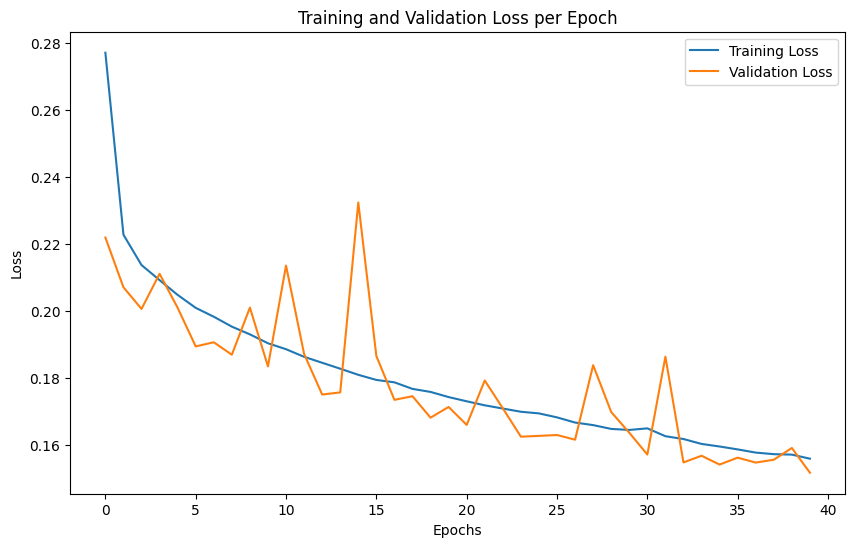

In [15]:
# Extracting training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the losses per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

In [16]:
# Separate features and target for the price prediction model
X_train_calls = df_train_calls.drop(columns=['is_buy','close'])  # Features for price prediction
y_train_price_full = df_train_calls['close']  # Target price

# Generate the 'purchasable' predictions using the classifier
purchasable_mask = binary_classifier_calls.predict(X_train_calls) >= 1  # Prediction mask for purchasable options

# Filter rows for the price prediction model based on the 'purchasable' mask
X_train_price = X_train_calls[purchasable_mask.flatten()]  # Only rows classified as purchasable
y_train_price = y_train_price_full[purchasable_mask.flatten()]  # Corresponding target prices for purchasable options

9007/9007 ━━━━━━━━━━━━━━━━━━━━ 2s 169us/step


## 2.2 Stage 2 Model (Price Prediction)

The followering hyper parameters were determined in [Section 2.4.2](#242-hyperparam-tuning-price-prediction) of hyperparameter tuning.
- Hidden Layer 1 No. of Neurons: 14
- Hidden Layer 2 No. of Neurons: 28
- Model Learning Rate: 0.01
- Epochs: 20
- Batch Size: 64

In [17]:
# Define the price prediction model
price_prediction_model_calls = Sequential()

# Input layer with 14 neurons
price_prediction_model_calls.add(Input(shape=(14,))) # 14 input features

# First hidden layer with 14 neurons
price_prediction_model_calls.add(Dense(units=42))  # 14 neurons
price_prediction_model_calls.add(LeakyReLU(negative_slope=0.01))               # Leaky ReLU activation

# Second hidden layer with 28 neurons and Leaky ReLU activation
price_prediction_model_calls.add(Dense(units=7))
price_prediction_model_calls.add(LeakyReLU(negative_slope=0.01))

# Output layer with 1 neuron (no activation for regression)
price_prediction_model_calls.add(Dense(units=1))

# Compile the model with Mean Squared Error (MSE) as the loss function for regression
price_prediction_model_calls.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Summary of the model architecture
price_prediction_model_calls.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 42)             │           630 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           301 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939 (3.67 KB)

 Trainable params: 939 (3.67 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the price prediction model
history = price_prediction_model_calls.fit(X_train_price, y_train_price, epochs=40, batch_size=64, validation_split=0.2)

Epoch 1/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21364.4414 - val_loss: 8312.8389
Epoch 2/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23340.0156 - val_loss: 5656.0684
Epoch 3/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 18355.4219 - val_loss: 4246.5854
Epoch 4/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 6948.8228 - val_loss: 2232.6470
Epoch 5/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 4362.4604 - val_loss: 738.1132
Epoch 6/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 1491.5292 - val_loss: 121.2208
Epoch 7/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 126.1269 - val_loss: 15.9859
Epoch 8/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 17.9137 - val_loss: 4.8728
Epoch 9/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 6.1685 - val_loss: 2.8045
Epoch 10/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 4.0115 - val_loss: 1.8541
Epoch 11/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 3.8934 - val_loss: 1.3642
Epoch 12/40
48/

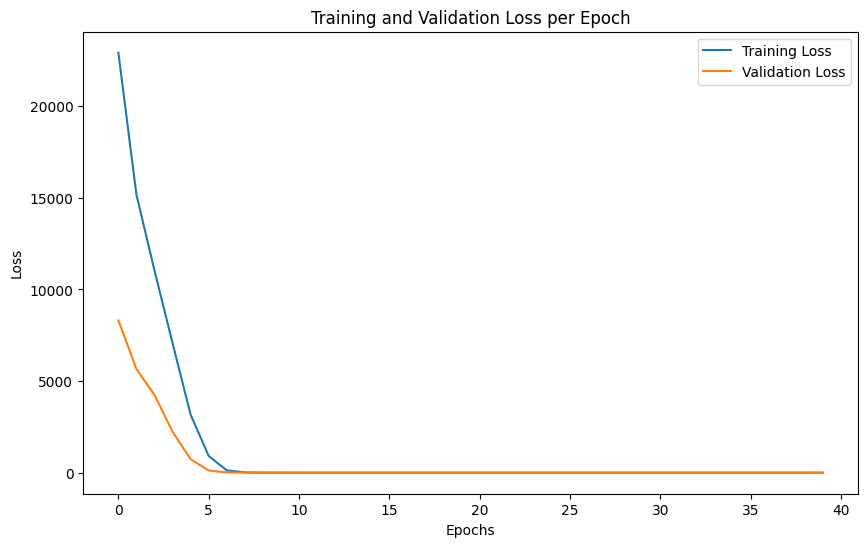

In [19]:
# Extracting training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the losses per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

## 2.3 Testing model

Testing is performed on a 6th day of trading not included in the training data

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [21]:
# Features and target for binary classification model
X_test_classification = df_test_calls.drop(columns=['close', 'is_buy'])  # Features for binary classification
y_test_classification = df_test_calls['is_buy']           # Binary target for classification

# Features and target for price prediction model
X_test_price = df_test_calls.drop(columns=['is_buy', 'close'])  # Features for price prediction
y_test_price_full = df_test_calls['close']                      # Target price for price prediction

In [22]:
y_pred_binary = (binary_classifier_calls.predict(X_test_classification).flatten() >= 0.5).astype(int)

# Calculate binary classifier metrics
binary_accuracy = accuracy_score(y_test_classification, y_pred_binary)
binary_precision = precision_score(y_test_classification, y_pred_binary)
binary_recall = recall_score(y_test_classification, y_pred_binary)
binary_f1 = f1_score(y_test_classification, y_pred_binary)

print("Binary Classifier Metrics:")
print(f"Accuracy: {binary_accuracy}")
print(f"Precision: {binary_precision}")
print(f"Recall: {binary_recall}")
print(f"F1-Score: {binary_f1}")


1769/1769 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
Binary Classifier Metrics:
Accuracy: 0.9501784389244197
Precision: 0.9128371628371629
Recall: 0.5966372837087822
F1-Score: 0.721618953603159


In [23]:
# Step 2: Filter Data for Stage 2 Price Prediction
purchasable_mask = (y_pred_binary == 1)  # Mask for options classified as "purchasable"

# Apply the mask to get features and target for price prediction
X_test_price_purchasable = X_test_price[purchasable_mask]
y_test_price = y_test_price_full[purchasable_mask]

In [24]:
# Step 3: Run Stage 2 Price Prediction
if len(X_test_price_purchasable) > 0:
    y_pred_price = price_prediction_model_calls.predict(X_test_price_purchasable)

    # Calculate regression metrics
    mse = mean_squared_error(y_test_price, y_pred_price)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_price, y_pred_price)
    r2 = r2_score(y_test_price, y_pred_price)

    print("\nPrice Prediction Model Metrics:")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")
else:
    print("\nNo 'purchasable' options found for price prediction in the 6th day test set.")

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step

Price Prediction Model Metrics:
Mean Squared Error: 371.82662350664646
Root Mean Squared Error: 19.28280642195649
Mean Absolute Error: 6.14380335195699
R-squared: 0.9196720698880312


## 2.4 Hyperparam Tuning

### 2.4.1 Hyperparam Tuning (Binary Classifier)

In [201]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV 

In [23]:
# Define the model-building function for Random Search
def build_binary_classifier_model(units=28, learning_rate=1e-3):
    model = Sequential()
    
    # Define the input layer separately using Input()
    model.add(Input(shape=(14,)))
    
    # Hidden layer with Leaky ReLU activation (using `negative_slope` instead of `alpha`)
    model.add(Dense(units=units))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Output layer with 1 neuron and sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model with specified learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Wrap the model using KerasClassifier, passing the function as build_fn
binary_classifier = KerasClassifier(model=build_binary_classifier_model, verbose=0)


In [24]:
param_grid = {
    'model__units': [14, 28, 56],            # Number of neurons in the hidden layer
    'model__learning_rate': [1e-2, 1e-3, 1e-4],  # Learning rates to try
    'batch_size': [16, 32, 64],              # Batch sizes to try
    'epochs': [10, 20]                       # Number of epochs to train
}

In [ ]:
# Initialize RandomizedSearchCV with the desired number of iterations
random_search = RandomizedSearchCV(estimator=binary_classifier, param_distributions=param_grid, 
                                   scoring='accuracy', cv=3, n_iter=10, random_state=42)

# Fit RandomizedSearchCV
X_train = df_train_calls.drop(columns=['close', 'is_buy'])  # Drop 'close' and 'is_buy' from features
y_train = df_train_calls['is_buy']  # Target for binary classification
random_search_result = random_search.fit(X_train, y_train)

# Get the best hyperparameters and score
print(f"Best Hyperparameters: {random_search_result.best_params_}")
print(f"Best Score: {random_search_result.best_score_}")


### 2.4.2 Hyperparam Tuning (Price Prediction)

In [202]:
from scikeras.wrappers import KerasRegressor

In [203]:
# Define the model-building function
def build_price_prediction_model(units1=28, units2=14, learning_rate=1e-3):
    model = Sequential()
    
    # Input and first hidden layer
    model.add(Input(shape=(14,)))
    model.add(Dense(units=units1))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Second hidden layer
    model.add(Dense(units=units2))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Output layer
    model.add(Dense(units=1))  # No activation function for regression
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [204]:
# Wrap the model with KerasRegressor
price_prediction_model = KerasRegressor(model=build_price_prediction_model, verbose=0)

In [205]:
param_grid = {
    'model__units1': [14, 28, 35, 42, 49, 58],               # Number of neurons in the first hidden layer
    'model__units2': [7, 14, 28, 35, 42, 49],                # Number of neurons in the second hidden layer
    'model__learning_rate': [1e-2, 1e-3, 1e-4, 1e-5],  # Learning rates to try
    'batch_size': [16, 32, 64],                  # Batch sizes to try
    'epochs': [10, 20, 30, 40]                           # Number of epochs
}

In [ ]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=price_prediction_model, param_distributions=param_grid, 
                                   scoring='neg_mean_squared_error', n_iter=10, cv=3, random_state=42)

# Fit RandomizedSearchCV
X_train = df_train_calls.drop(columns=['close', 'is_buy'])  # Features for training
y_train = df_train_calls['close']  # Target prices for training
random_search_result = random_search.fit(X_train, y_train)

# Get the best hyperparameters and score
print(f"Best Hyperparameters: {random_search_result.best_params_}")
print(f"Best Score (Negative MSE): {random_search_result.best_score_}")


# 3. Model for Puts ONLY

In [25]:
# Scaling
numerical_columns = ['strike', 'trade_volume', 'active_underlying_price', 
                     'implied_volatility', 'delta', 'gamma', 'theta', 
                     'vega', 'rho', 'open_interest', 'time_to_expiration', 'bid_ask_spread']
scaler = StandardScaler()
df_train_puts[numerical_columns] = scaler.fit_transform(df_train_puts[numerical_columns])
df_test_puts[numerical_columns] = scaler.transform(df_test_puts[numerical_columns])

## 3.1 Stage 1 Model (Binary Classifier)

The followering hyper parameters were determined in [Section 3.4.1](#341-hyperparam-tuning-binary-classifier) of hyperparameter tuning.
- Hidden Layer No. of Neurons: 14
- Model Learning Rate: 0.001
- Epochs: 20
- Batch Size: 16

In [26]:
# Define the binary classifier model
binary_classifier_puts = Sequential()

# Input layer with 14 neurons for 14 features
binary_classifier_puts.add(Input(shape=(14,)))

# Hidden layer with 14 neurons
binary_classifier_puts.add(Dense(units=14))
binary_classifier_puts.add(LeakyReLU(negative_slope=0.01))         # Leaky ReLU activation

# Output layer with 1 neuron and sigmoid activation for binary classification
binary_classifier_puts.add(Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss and Adam optimizer
binary_classifier_puts.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
binary_classifier_puts.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 14)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Separate features and target for training
X_train = df_train_puts.drop(columns=['close', 'is_buy'])  # Drop 'close' and 'is_buy' from features
y_train = df_train_puts['is_buy']  # Target for binary classification

In [28]:
# Training the binary classifier
history = binary_classifier_puts.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)


Epoch 1/20
14410/14410 ━━━━━━━━━━━━━━━━━━━━ 4s 264us/step - accuracy: 0.8663 - loss: 0.3521 - val_accuracy: 0.9075 - val_loss: 0.2588
Epoch 2/20
14410/14410 ━━━━━━━━━━━━━━━━━━━━ 4s 255us/step - accuracy: 0.9049 - loss: 0.2688 - val_accuracy: 0.9236 - val_loss: 0.2231
Epoch 3/20
14410/14410 ━━━━━━━━━━━━━━━━━━━━ 4s 260us/step - accuracy: 0.9187 - loss: 0.2442 - val_accuracy: 0.9276 - val_loss: 0.2247
Epoch 4/20
14410/14410 ━━━━━━━━━━━━━━━━━━━━ 4s 251us/step - accuracy: 0.9251 - loss: 0.2232 - val_accuracy: 0.9281 - val_loss: 0.2930
Epoch 5/20
14410/14410 ━━━━━━━━━━━━━━━━━━━━ 4s 281us/step - accuracy: 0.9290 - loss: 0.2231 - val_accuracy: 0.9393 - val_loss: 0.1943
Epoch 6/20
14410/14410 ━━━━━━━━━━━━━━━━━━━━ 4s 262us/step - accuracy: 0.9343 - loss: 0.2080 - val_accuracy: 0.9382 - val_loss: 0.1849
Epoch 7/20
14410/14410 ━━━━━━━━━━━━━━━━━━━━ 4s 250us/step - accuracy: 0.9368 - loss: 0.1957 - val_accuracy: 0.9351 - val_loss: 0.2349
Epoch 8/20
14410/14410 ━━━━━━━━━━━━━━━━━━━━ 4s 259us/step - ac

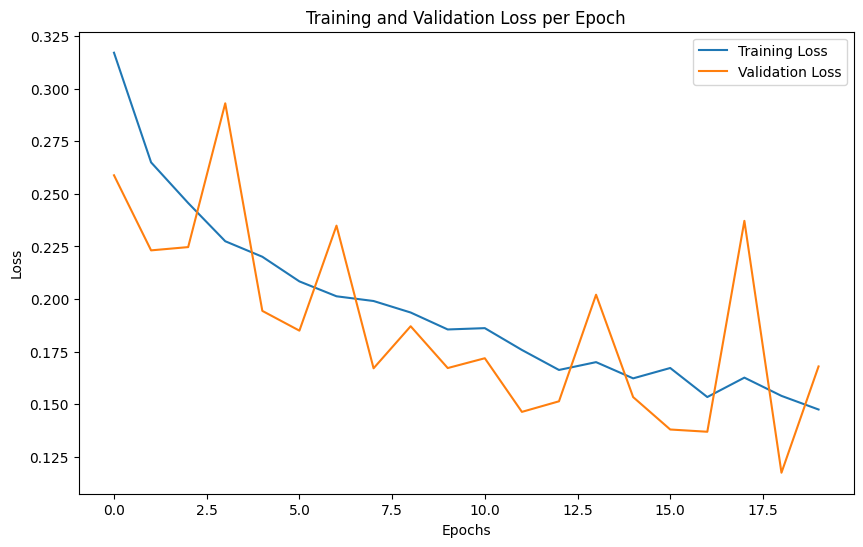

In [29]:
# Extracting training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the losses per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

In [30]:
# Separate features and target for the price prediction model
X_train_puts = df_train_puts.drop(columns=['is_buy','close'])  # Features for price prediction
y_train_price_full = df_train_puts['close']  # Target price

# Generate the 'purchasable' predictions using the classifier
purchasable_mask = binary_classifier_puts.predict(X_train_puts) >= 1  # Prediction mask for purchasable options

# Filter rows for the price prediction model based on the 'purchasable' mask
X_train_price = X_train_puts[purchasable_mask.flatten()]  # Only rows classified as purchasable
y_train_price = y_train_price_full[purchasable_mask.flatten()]  # Corresponding target prices for purchasable options

9007/9007 ━━━━━━━━━━━━━━━━━━━━ 2s 169us/step


## 3.2 Stage 2 Model (Price Prediction)

The followering hyper parameters were determined in [Section 3.4.2](#342-hyperparam-tuning-price-prediction) of hyperparameter tuning.
- Hidden Layer 1 No. of Neurons: 14
- Hidden Layer 2 No. of Neurons: 28
- Model Learning Rate: 0.001
- Epochs: 20
- Batch Size: 32

In [31]:
# Define the price prediction model
price_prediction_model_puts = Sequential()

# Input layer with 14 neurons and first hidden layer with 14 neurons
price_prediction_model_puts.add(Input(shape=(14,)))
price_prediction_model_puts.add(Dense(units=14))
price_prediction_model_puts.add(LeakyReLU(negative_slope=0.01))               # Leaky ReLU activation

# Second hidden layer with 28 neurons and Leaky ReLU activation
price_prediction_model_puts.add(Dense(units=28))
price_prediction_model_puts.add(LeakyReLU(negative_slope=0.01))

# Output layer with 1 neuron (no activation for regression)
price_prediction_model_puts.add(Dense(units=1))

# Compile the model with Mean Squared Error (MSE) as the loss function for regression
price_prediction_model_puts.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Summary of the model architecture
price_prediction_model_puts.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 14)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 28)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            29 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 659 (2.57 KB)

 Trainable params: 659 (2.57 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Train the price prediction model
history = price_prediction_model_puts.fit(X_train_price, y_train_price, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 288.7078 - val_loss: 0.9044
Epoch 2/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - loss: 1.9547 - val_loss: 0.6367
Epoch 3/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - loss: 1.7372 - val_loss: 0.4873
Epoch 4/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step - loss: 1.7111 - val_loss: 0.6119
Epoch 5/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - loss: 1.6426 - val_loss: 0.4883
Epoch 6/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - loss: 1.8642 - val_loss: 0.4036
Epoch 7/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - loss: 1.8308 - val_loss: 0.5951
Epoch 8/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - loss: 1.6439 - val_loss: 0.5764
Epoch 9/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - loss: 1.5300 - val_loss: 0.5398
Epoch 10/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step - loss: 1.4159 - val_loss: 0.4554
Epoch 11/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - loss: 1.6114 - val_loss: 0.7518
Epoch 12/20
311/311 ━━━━━━━━

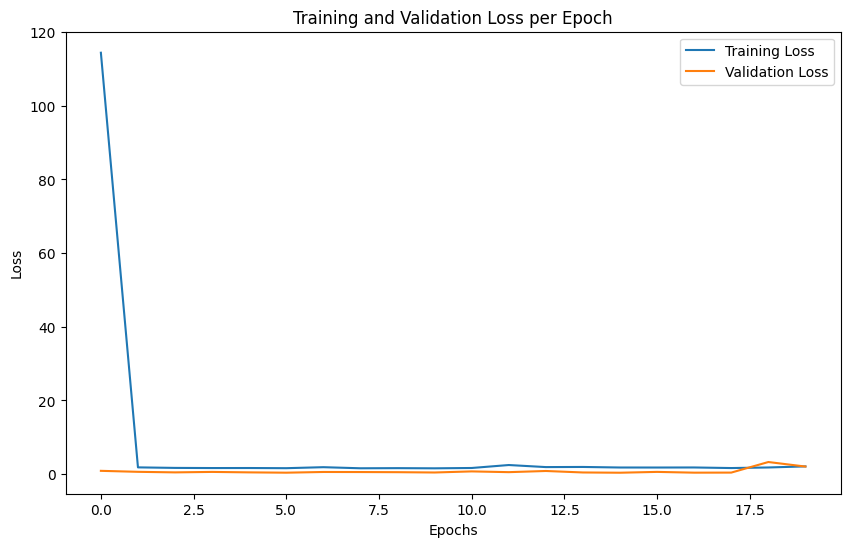

In [33]:
# Extracting training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the losses per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

## 3.3 Testing model

Testing is performed on a 6th day of trading not included in the training data

In [34]:
# Features and target for binary classification model
X_test_classification = df_test_puts.drop(columns=['close', 'is_buy'])  # Features for binary classification
y_test_classification = df_test_puts['is_buy']           # Binary target for classification

# Features and target for price prediction model
X_test_price = df_test_puts.drop(columns=['is_buy', 'close'])  # Features for price prediction
y_test_price_full = df_test_puts['close']                      # Target price for price prediction

In [35]:
y_pred_binary = (binary_classifier_puts.predict(X_test_classification).flatten() >= 0.5).astype(int)

# Calculate binary classifier metrics
binary_accuracy = accuracy_score(y_test_classification, y_pred_binary)
binary_precision = precision_score(y_test_classification, y_pred_binary)
binary_recall = recall_score(y_test_classification, y_pred_binary)
binary_f1 = f1_score(y_test_classification, y_pred_binary)

print("Binary Classifier Metrics:")
print(f"Accuracy: {binary_accuracy}")
print(f"Precision: {binary_precision}")
print(f"Recall: {binary_recall}")
print(f"F1-Score: {binary_f1}")


1769/1769 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step
Binary Classifier Metrics:
Accuracy: 0.9424931981202078
Precision: 0.8617217998767208
Recall: 0.8146061959794115
F1-Score: 0.8375018720982477


In [36]:
# Step 2: Filter Data for Stage 2 Price Prediction
purchasable_mask = (y_pred_binary == 1)  # Mask for options classified as "purchasable"

# Apply the mask to get features and target for price prediction
X_test_price_purchasable = X_test_price[purchasable_mask]
y_test_price = y_test_price_full[purchasable_mask]

In [37]:
# Step 3: Run Stage 2 Price Prediction
if len(X_test_price_purchasable) > 0:
    y_pred_price = price_prediction_model_puts.predict(X_test_price_purchasable)

    # Calculate regression metrics
    mse = mean_squared_error(y_test_price, y_pred_price)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_price, y_pred_price)
    r2 = r2_score(y_test_price, y_pred_price)

    print("\nPrice Prediction Model Metrics:")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")
else:
    print("\nNo 'purchasable' options found for price prediction in the 6th day test set.")

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step

Price Prediction Model Metrics:
Mean Squared Error: 37.700084396026746
Root Mean Squared Error: 6.140039445803809
Mean Absolute Error: 3.141102736094649
R-squared: 0.9657947678052679


## 3.4 Hyperparam Tuning

### 3.4.1 Hyperparam Tuning (Binary Classifier)

In [42]:
# Define the model-building function for Random Search
def build_binary_classifier_model(units=28, learning_rate=1e-3):
    model = Sequential()
    
    # Define the input layer separately using Input()
    model.add(Input(shape=(14,)))
    
    # Hidden layer with Leaky ReLU activation (using `negative_slope` instead of `alpha`)
    model.add(Dense(units=units))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Output layer with 1 neuron and sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model with specified learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Wrap the model using KerasClassifier, passing the function as build_fn
binary_classifier = KerasClassifier(model=build_binary_classifier_model, verbose=0)


In [43]:
param_grid = {
    'model__units': [14, 28, 56],            # Number of neurons in the hidden layer
    'model__learning_rate': [1e-2, 1e-3, 1e-4],  # Learning rates to try
    'batch_size': [16, 32, 64],              # Batch sizes to try
    'epochs': [10, 20]                       # Number of epochs to train
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize RandomizedSearchCV with the desired number of iterations
random_search = RandomizedSearchCV(estimator=binary_classifier, param_distributions=param_grid, 
                                   scoring='accuracy', cv=3, n_iter=10, random_state=42)

# Fit RandomizedSearchCV
X_train = df_train_puts.drop(columns=['close', 'is_buy'])  # Drop 'close' and 'is_buy' from features
y_train = df_train_puts['is_buy']  # Target for binary classification
random_search_result = random_search.fit(X_train, y_train)

# Get the best hyperparameters and score
print(f"Best Hyperparameters: {random_search_result.best_params_}")
print(f"Best Score: {random_search_result.best_score_}")


### 3.4.2 Hyperparam Tuning (Price Prediction)

In [45]:
# Define the model-building function
def build_price_prediction_model(units1=28, units2=14, learning_rate=1e-3):
    model = Sequential()
    
    # Input and first hidden layer
    model.add(Input(shape=(14,)))
    model.add(Dense(units=units1))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Second hidden layer
    model.add(Dense(units=units2))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Output layer
    model.add(Dense(units=1))  # No activation function for regression
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [46]:
# Wrap the model with KerasRegressor
price_prediction_model = KerasRegressor(model=build_price_prediction_model, verbose=0)

In [47]:
param_grid = {
    'model__units1': [14, 28, 54],               # Number of neurons in the first hidden layer
    'model__units2': [7, 14, 28],                # Number of neurons in the second hidden layer
    'model__learning_rate': [1e-2, 1e-3, 1e-4],  # Learning rates to try
    'batch_size': [16, 32, 64],                  # Batch sizes to try
    'epochs': [10, 20]                           # Number of epochs
}

In [ ]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=price_prediction_model, param_distributions=param_grid, 
                                   scoring='neg_mean_squared_error', n_iter=10, cv=3, random_state=42)

# Fit RandomizedSearchCV
X_train = df_train_puts.drop(columns=['close', 'is_buy'])  # Features for training
y_train = df_train_puts['close']  # Target prices for training
random_search_result = random_search.fit(X_train, y_train)


# Get the best hyperparameters and score
print(f"Best Hyperparameters: {random_search_result.best_params_}")
print(f"Best Score (Negative MSE): {random_search_result.best_score_}")
